# Objectness distribution in space
The purpose of this notebook is to vizualize how objectness changes when the bounding box is shifted from the ground truth location. For this purpose, let $n \times m$ be the size of the image $I$, and let $bb(t)=\{x,y,w,h\}$ be the bounding box at time $t$. Also, let $O_{edge}(x,y), O_{straddling}(x,y)$ be the function of edge and straddling objectness measure as functions of the center of the bounding box. The problem is to plot $O_{edge}, O_{straddling}$.

In [ ]:
# Import C++ implementation of the objectness.
import sys
sys.path.append('../../Experiments')
import objectness

## Load Data
Load the image and corresponding bounding box.

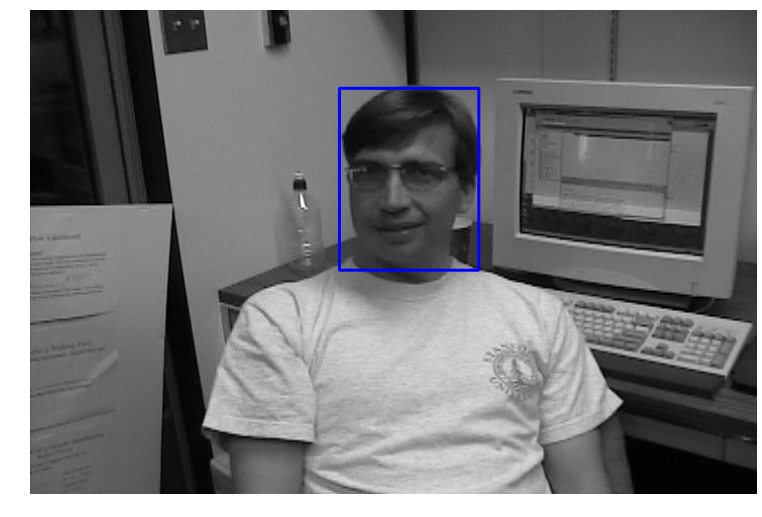

In [5]:
sys.path.append('../../Evaluation')
#from  Evaluation import  DatasetEvaluation
import DatasetEvaluation
import cv2
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

### CHANGE THIS PARAETERS, IF NECESSARY
vidName="dudek"
imageNumber=150;

fig_x_size=13
fig_y_size=10

wu2013GroundTruth="/Users/Ivan/Files/Data/Tracking_benchmark"
datasetType='wu2013'

dataset=DatasetEvaluation.Dataset(wu2013GroundTruth,datasetType)
d=dataset.dictData;



# get the dictionary
vidDictionary=[x for x in d if x["name"]==vidName][0]
# get the bounding box
box=vidDictionary['boxes'][imageNumber]
# get the image
ImName=vidDictionary['images'][imageNumber]
I=cv2.imread(ImName)
I=cv2.cvtColor(I, cv2.COLOR_BGR2RGB)

pt1=(int(box[0]),int(box[1]))
pt2=(int(box[0]+box[2]),int(box[1]+box[3]))
cv2.rectangle(I,pt1,pt2,(0,0,255),2)
plt.figure(figsize=(fig_x_size, fig_y_size))
plt.imshow(I)
plt.axis("off")
plt.show()

In [6]:
box=np.round(box)


# create objectness object
objness=objectness.Objectness()

edge_t1=1
edge_t2=200
inner_rectangle=0.95
nSuperpixels=500

# needs around 1272 per objectness measure
import os.path
import time
outfileEdge=vidName+'_edge_'+str(imageNumber);
outfileStraddling=vidName+'_straddling_'+str(imageNumber);

if (not os.path.isfile(outfileEdge+'.npy')) or (not os.path.isfile(outfileStraddling+'.npy')):
    O_edge=np.zeros((I.shape[0],I.shape[1]))
    O_straddling=np.zeros((I.shape[0],I.shape[1]))
    t0 = time.time()
    # iterate over all possible locations of the boundig box
    
    objness.readImage(ImName);
    objness.initializeStraddling(nSuperpixels,inner_rectangle);
    objness.initializeEdgeDensity(edge_t1,edge_t2,inner_rectangle);
    
    for y in range(0,I.shape[0]):
        for x in range(0,I.shape[1]):
            # create a bounding box centered at x,y
            b=[ x-box[2]/2,y-box[3]/2,box[2],box[3]]

            # make sure the bounding box fits the image
            if (b[0]<0 or b[0]+box[2]>=I.shape[1]) or (b[1]<0 or b[1]+box[3]>=I.shape[0]):
                continue

            #objness.initialize(ImName, int(b[0]), int(b[1]), int(b[2]), int(b[3]))
            
            if (not os.path.isfile(outfileEdge+'.npy')):
                O_edge[y][x]=objness.getEdgeness(int(b[0]), int(b[1]), int(b[2]), int(b[3]))
                
            if (not os.path.isfile(outfileStraddling+'.npy')):
                O_straddling[y][x]=objness.getStraddling(int(b[0]), int(b[1]), int(b[2]), int(b[3]))
    t1=time.time()

    total_time=t1-t0;
    #np.save(outfileEdge,O_edge)
    #np.save(outfileStraddling,O_straddling)
else:
    O_edge=np.load(outfileEdge+'.npy')
    O_straddling=np.load(outfileStraddling+'.npy')

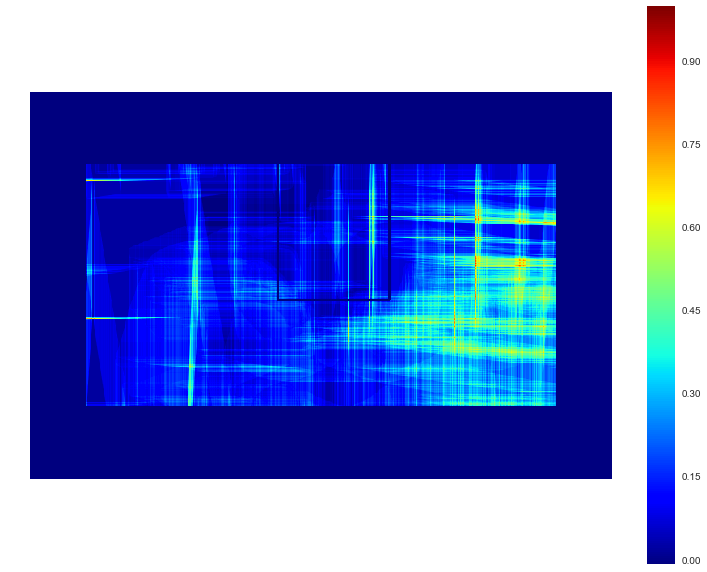

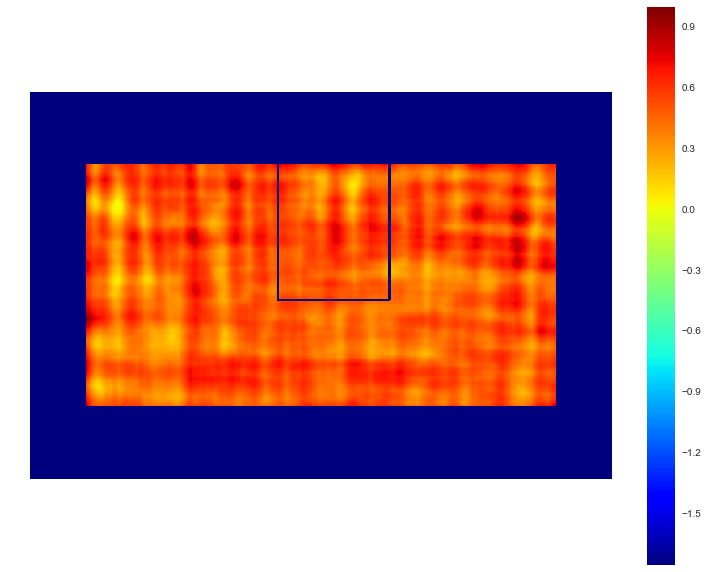

In [13]:
#normalize first

def normalize(d):
    
    d_pos=d[d>0]
    maxValue=np.max(np.max(d_pos))
    minValue=np.min(np.min(d_pos))
    
    d=(d-minValue)/(maxValue-minValue)
    return d



cv2.rectangle(O_edge,pt1,pt2,(0,0,255),2)
cv2.rectangle(O_straddling,pt1,pt2,(0,0,255),2)

O_edge=normalize(O_edge)
O_straddling=normalize(O_straddling)

plt.figure(figsize=(fig_x_size, fig_y_size))
plt.matshow(O_edge,fignum=0,cmap=plt.get_cmap("jet"))
plt.colorbar()
plt.axis('off')
plt.show()

plt.figure(figsize=(fig_x_size, fig_y_size))
plt.matshow(O_straddling,fignum=0,cmap=plt.get_cmap("jet"))
plt.colorbar()
plt.axis('off')
plt.show()